### Jupyter for making figure for fastDMF+plastic FIC
#### I.- Inhibitory homeostatic plasticity rule enhances model stability and plausibility
    
    1.- Decay vs Learning rate relationship for different objective firing rates    
    2.- Firing Rate comparison between static vs dynamic FIC    
    3.- Convergence of dynamic FIC to the linear solution
    4.- Comparison of firing rate under neuromodulation


#### II.- Fitting to fMRI

    1.- Objective function for static and dynamics FIC for FC    
    2.- Violin plot of the fit to FC at the optimum    
    3.- Objective function for static and dynamics FIC for FCD    
    4.- Violin plot of the fit to FCD at the optimum


#### III.- A potential mechanism for whole-brain slow-waves
    1.- G vs LR Parameter space with autocorrelation peak
    2.- G vs LR Parameter space with autocorrelation time to peak
    3.- Average firing rate trace at slow wave region
    4.- Average firing rate trace at no-slow wave region (best fit to wake data)

In [3]:
# ! pip install mat73

In [2]:
import os
import time
import seaborn as sns
import numpy as np
import pandas as pd
# import fastdyn_fic_dmf as dmf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy import stats
import mat73
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
from matplotlib.gridspec import GridSpec


### I.- Inhibitory homeostatic plasticity rule enhances model stability and plausibility

In [6]:
# Loading data
# datafolder = 'C:/Users/rherz/OneDrive/Documents/Projects/dynFIC/data2plot/'
# figfold = 'C:/Users/rherz/OneDrive/Documents/Projects/dynFIC/paper_fig/paper_figs/figures/'
#datafolder = '/home/ruben.herzog/OneDrive/Projects/dynFIC/data2plot/'
#figfold = '/home/ruben.herzog/OneDrive/Projects/dynFIC/paper_figs/figures/'
datafolder = '/home/ivan.mindlin/Desktop/DatosParaRuben/'
figfold = '/network/lustre/iss02/home/ivan.mindlin/dyn_fic_dmf/paper_figs'
# Homeostatic fit
hom_fit_list = [] # 0=1.22, 1=3.44, 2=6.88, 3=50
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit1-22-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit3-44-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit6-88-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit50-Grid/hom_grid.npy'))

# Static vs Dynamic FIC comparison
all_rates = np.load(datafolder+'ChequeoPreliminar/all_rates.npy')
fic_t = np.load(datafolder+'ChequeoPreliminar/fic_t.npy')
static_fic = np.load(datafolder+'ChequeoPreliminar/static_fic.npy')

# Neuromodulation
nm_mean_fr = [] # 0 is static, 1 dynamic
nm_std_fr = [] # 0 is static, 1 dynamic
nm_fc = [] # 0 is static, 1 dynamic
nm_fcd = [] # 0 is static, 1 dynamic
nm_mean_fr.append(np.load(datafolder+'neuromod/static/mean_fr_grid.npy'))
nm_mean_fr.append(np.load(datafolder+'neuromod/dynamic/mean_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/static/std_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/dynamic/std_fr_grid.npy'))
# nm_fc.append(np.load(datafolder+'neuromod/static/mean_fc_grid.npy'))
# nm_fc.append(np.load(datafolder+'neuromod/dynamic/mean_fc_grid.npy'))
# nm_fcd.append(np.load(datafolder+'neuromod/static/sim_stds_grid.npy'))
# nm_fcd.append(np.load(datafolder+'neuromod/dynamic/sim_stds_grid.npy'))

# Slow waves
peak_val_ac_grid = np.load(datafolder+'slow_waves/peak_autocorrelation_grid.npy')
peak_time_ac_grid = np.load(datafolder+'slow_waves/peak_time_grid.npy')
corr_to_sc_grid = np.load(datafolder+'slow_waves/corr_to_sc_grid.npy')
rates_grid = np.load(datafolder+'slow_waves/rates_grid.npy')
homeo_fit_grid = np.load(datafolder+'slow_waves/homeostatic_fittness_grid.npy')




#### Homeostatic Fit

In [7]:
# HOMEOSTATIC FIT
# Extracting averages over the range of G
G_range = np.arange(0,8.5, 0.5)
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
obj_rates = [1.22, 3.44, 6.88, 50]

nobjs = len(obj_rates)
ngs = len(G_range)
nlr = len(LR_range)
ndec = len(DECAY_range)
lr_labels = [1, 10, 100, 1000]
dec_labels = [100, 1000, 10000, 100000]

# Mean and average over G
mean_hom_fit = [np.mean(x,axis=2) for x in hom_fit_list]
std_hom_fit = [np.std(x,axis=2) for x in hom_fit_list]

# Extracting Minimum mismatch
min_mm_pos = [np.argmin(np.abs(x),axis=0) for x in mean_hom_fit]

# Fitting linear trend
fit_res = list()
fit_res_2plot = list()
for o in range(nobjs):
    if o==0:
        fit_res.append(np.polyfit(LR_range[21:], min_mm_pos[o][21:], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr)[21:], min_mm_pos[o][21:], 1))
    else:
        fit_res.append(np.polyfit(LR_range, min_mm_pos[o], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr), min_mm_pos[o], 1))    
    


### Acá falta el plot con la correlación del promedio del FIC vs la fuerza de conectividad

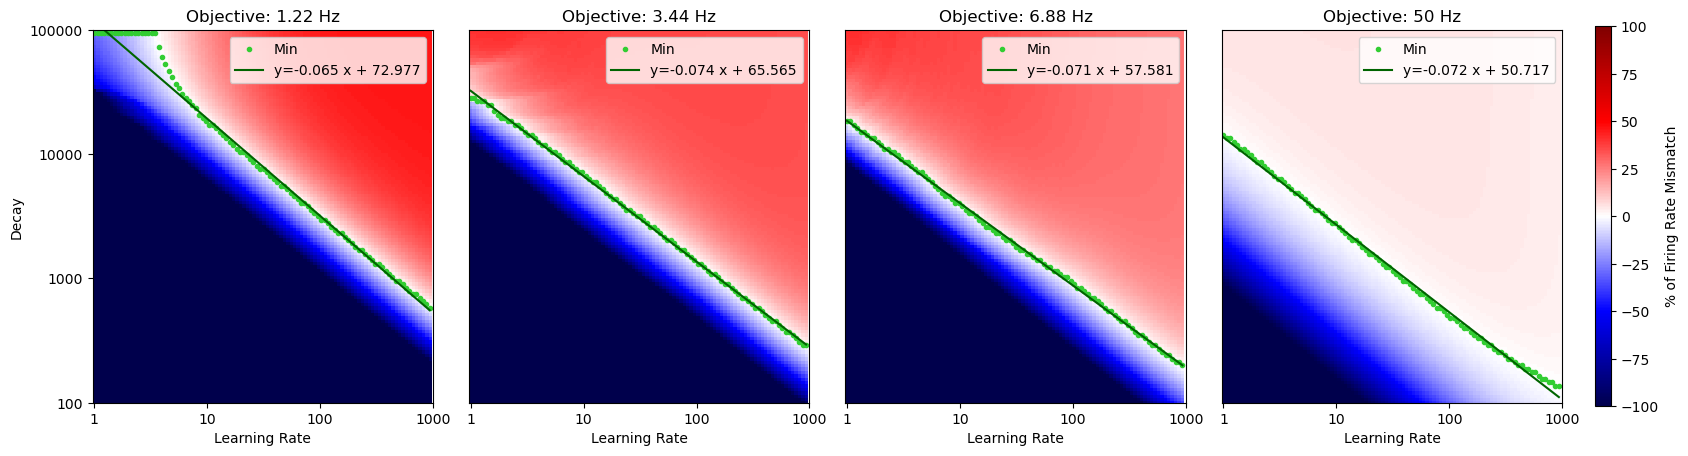

In [8]:
# Plotting Average over G
figname = 'lr_vs_decay_ave_mismatch'
fig = plt.figure(figsize=(16, 10))
for o in range(nobjs):
    # Average over G
    ax=plt.subplot(1,nobjs,o+1)
    plt.imshow(100*mean_hom_fit[o]/obj_rates[o], vmin=-100, vmax=100, cmap='seismic', origin='lower', interpolation='none')
    plt.plot(range(0,nlr),min_mm_pos[o],'.', label='Min', color='limegreen')
    plt.plot(range(0,nlr), fit_res_2plot[o][0]*range(0,nlr) + fit_res_2plot[o][1], '-', color='darkgreen',
             label='y='+"{:.3f}".format(fit_res[o][0])+' x + '+"{:.3f}".format((fit_res[o][1])))        
    plt.xticks(ticks=np.linspace(0,nlr, 4), labels=lr_labels)
    plt.xlabel('Learning Rate')
    plt.title('Objective: '+ str(obj_rates[o])+' Hz')
    plt.ylim([0,ndec])
    plt.legend()
    
    if o==0:
        plt.yticks(ticks=np.linspace(0,ndec, 4),labels=dec_labels )   
        plt.ylabel('Decay')
    else:
        plt.yticks(ticks=[])



plt.tight_layout()

cbar_ax = fig.add_axes([1, 0.31, 0.01, 0.38])
cbar = plt.colorbar(cax=cbar_ax)
cbar.set_label('% of Firing Rate Mismatch')

plt.show()

# fig.savefig(figfold+figname+'.png', dpi=300)
# fig.savefig(figfold+figname+'.pdf')

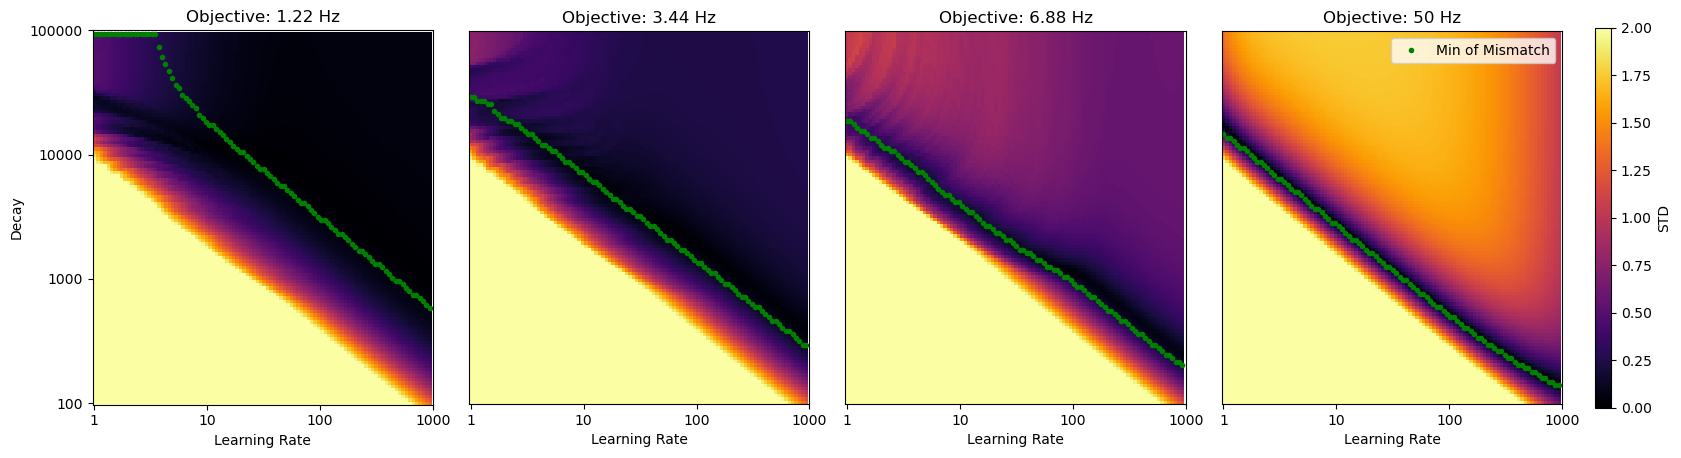

In [9]:
# Plotting STD
figname = 'lr_vs_decay_std_mismatch'
fig = plt.figure(figsize=(16, 10))
for o in range(nobjs):
    # STD over G
    ax=plt.subplot(1,nobjs,o+1)
    plt.imshow(std_hom_fit[o], vmin=0, vmax=2, cmap='inferno', origin='lower',interpolation='none')
    plt.plot(range(0,nlr),min_mm_pos[o],'g.', label='Min of Mismatch')    
    plt.xticks(ticks=np.linspace(0,nlr, 4), labels=lr_labels)
    plt.xlabel('Learning Rate')    
    plt.title('Objective: '+ str(obj_rates[o])+' Hz')
    
    if o==0:
        plt.yticks(ticks=np.linspace(0,ndec, 4),labels=dec_labels )   
        plt.ylabel('Decay')
    else:
        plt.yticks(ticks=[])

plt.legend()
plt.tight_layout()
cbar_ax2 = fig.add_axes([1, 0.31, 0.01, 0.38])
cbar2 = plt.colorbar(cax=cbar_ax2)
cbar2.set_label('STD')
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')

#### Comparison of static vs dynamic FIC



Acá falta agregar los paneles con correlación con la strength y la MSE.

También falta agregar en el primer panel el modelo estático que usar el promedio del FIC dinámico (mixed).


Hacer los gráficos usando el promedio de varias simulaciones para asegurarse que la inestabilidad del mixed es observada para diferentes codiciones iniciales.

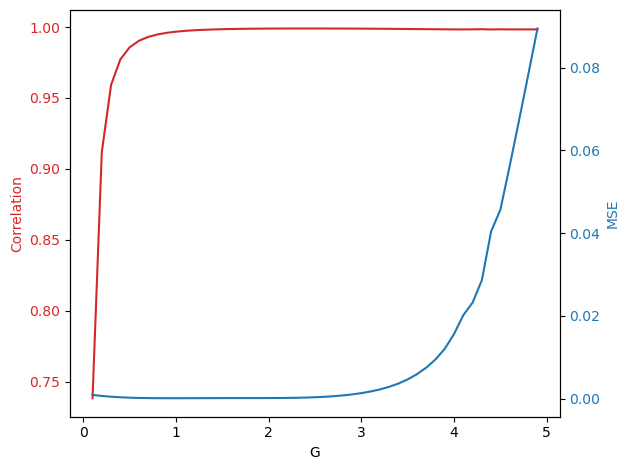

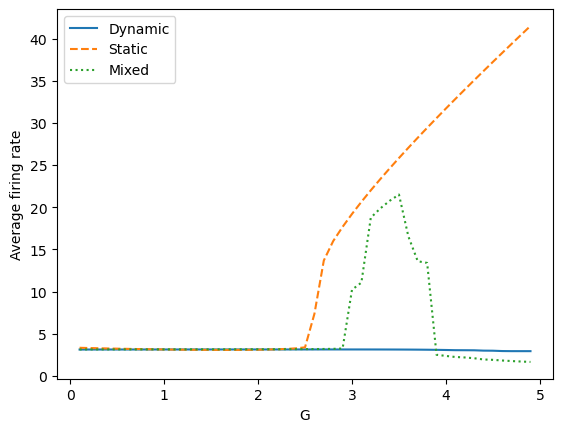

In [10]:
import numpy as np

# Define the data path
data_path = "/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar"

# Load the results from the specified directory
mse_values = np.load(os.path.join(data_path, "mse_values.npy"))
corr_values = np.load(os.path.join(data_path, "corr_values.npy"))
avg_fr_dyn_values = np.load(os.path.join(data_path, "avg_fr_dyn_values.npy"))
avg_fr_stat_values = np.load(os.path.join(data_path, "avg_fr_stat_values.npy"))
avg_fr_mixed_values = np.load(os.path.join(data_path, "avg_fr_mixed_values.npy"))
stat_fic_values = np.load(os.path.join(data_path, "stat_fic_values.npy"))
dyn_fic_values = np.load(os.path.join(data_path, "dyn_fic_values.npy"))
G_values = np.load(os.path.join(data_path, "G_values.npy"))


#Do a shared y-axis plot where in the left axis you show the correlation and in the right axis you show the MSE
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('G')
ax1.set_ylabel('Correlation', color=color)
ax1.plot(G_values, corr_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('MSE', color=color)  # we already handled the x-label with ax1
ax2.plot(G_values, mse_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
# add legend to distinguish between the two lines

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# plot thes average firing rates for the dynamic and static simulations
plt.figure()
plt.plot(G_values, np.mean(avg_fr_dyn_values, axis=1))
plt.plot(G_values, np.mean(avg_fr_stat_values, axis=1), '--')
plt.plot(G_values, np.mean(avg_fr_mixed_values, axis=1), ':')
plt.xlabel('G')
plt.ylabel('Average firing rate')
plt.legend(['Dynamic', 'Static', 'Mixed'])
plt.show()



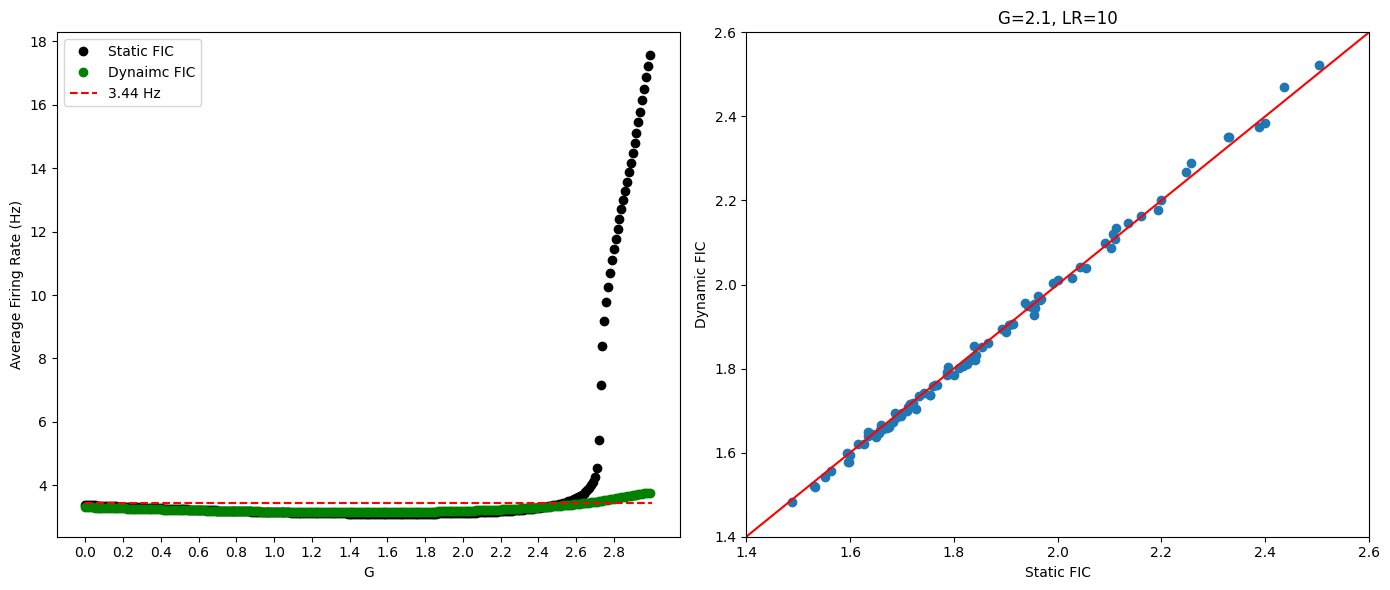

In [7]:
# Plotting FR vs G (bifurcation diagram)
G_range = np.arange(0,3,0.01)
figname = 'bif_diag_and_dyn_fic_vs_stat'
fig = plt.figure(figsize=(14, 6))

# Bifurcation
plt.subplot(1,2,1)

plt.plot(np.mean(all_rates, axis=2)[0],'o', color='k', label='Static FIC',alpha=1)
plt.plot(np.mean(all_rates, axis=2)[1],'o', color='g', label='Dynaimc FIC',alpha=1)
plt.plot([0,len(G_range)], [3.44, 3.44], 'r--', label='3.44 Hz')
xtick_positions = range(0, len(G_range), 20)
plt.xticks(ticks=xtick_positions, labels=[f"{G_range[i]:.1f}" for i in xtick_positions])
plt.xlabel("G")
plt.ylabel("Average Firing Rate (Hz)")
plt.legend()

# Static vs average dynamic FIC
plt.subplot(1,2,2)
plt.plot(static_fic,np.mean(fic_t[:,10000:],axis=1),'o')
plt.axline((1.5, 1.5), slope=1, color='red')
plt.xlabel('Static FIC')
plt.ylabel('Dynamic FIC')
plt.title('G=2.1, LR=10')
plt.ylim([1.4, 2.6])
plt.xlim([1.4, 2.6])


plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')

#### Neuromodulation with and without plasticity rule

In [27]:
## Computing the correlation between receptor density and firing rates for each learning rate
LR_range = np.logspace(0,2.46,10)
sc_rec = loadmat(datafolder+'SC_and_5ht2a_receptors.mat')
receptors = sc_rec['receptors']
nlrs = 10
polyfit_out_static = [np.polyfit(np.squeeze(receptors), nm_mean_fr[0][x].T, 1, full=True) for x in range(nlrs)]
polyfit_out_dyn = [np.polyfit(np.squeeze(receptors), nm_mean_fr[1][x].T, 1, full=True) for x in range(nlrs)]
corr_out_static = [1-cdist(receptors.T, nm_mean_fr[0][x],metric='correlation') for x in range(nlrs)]
corr_out_dyn = [1-cdist(receptors.T, nm_mean_fr[1][x],metric='correlation') for x in range(nlrs)]

slope_rec_fr = [np.vstack([x[0][0],y[0][0]]) for x,y in zip(polyfit_out_static,polyfit_out_dyn)]
res_rec_fr = [np.vstack([x[0][1],y[0][1]]) for x,y in zip(polyfit_out_static,polyfit_out_dyn)]
corr_rec_fr = [np.vstack([x,y]) for x,y in zip(corr_out_static,corr_out_dyn)]


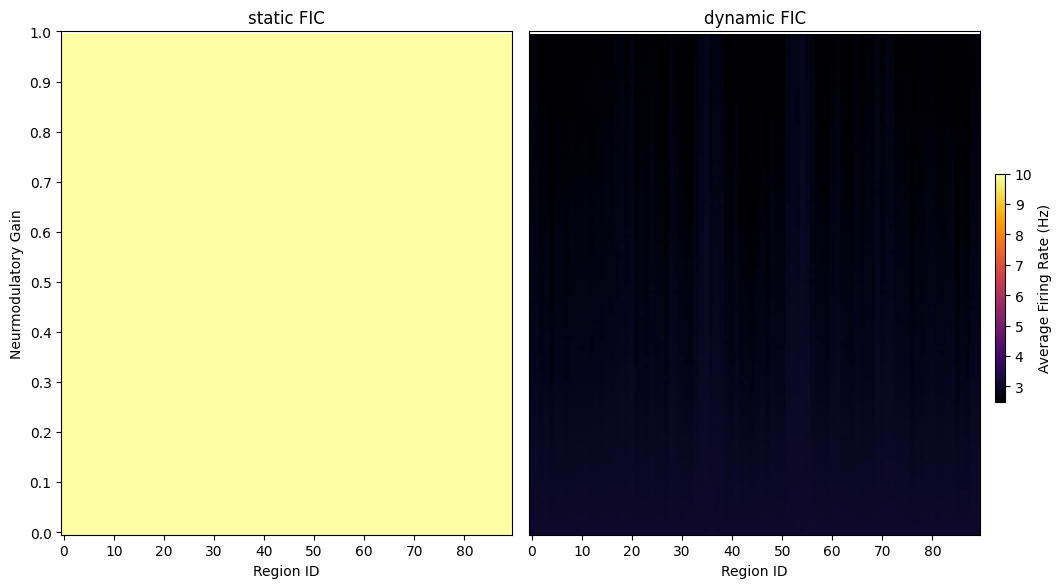

In [11]:
# Average Firing rate vs Neuromodulatory gain
figname = 'fr_vs_gain_lr_fix'
fig = plt.figure(figsize=(10, 6))
GAINE_range = np.arange(0,1,0.01)
ngain = len(GAINE_range)

min_fr = np.min([np.min(nm_mean_fr[0]),np.min(nm_mean_fr[1])])
max_fr = np.max([np.max(nm_mean_fr[0]),np.max(nm_mean_fr[1])])
titles = ['static FIC', 'dynamic FIC']

for d in range(2):
    plt.subplot(1,2,d+1)
    plt.imshow(nm_mean_fr[d][0,:,:], origin='lower', vmin=2.5, vmax=10, cmap='inferno', interpolation='none')
    plt.xlabel('Region ID')    
    plt.yticks(ticks=np.linspace(0,100,11), labels=np.floor(np.linspace(0,10,11))/10)
    plt.title(titles[d])
    if d==0:
        plt.ylabel('Neurmodulatory Gain')
    else:
        plt.yticks(ticks=[])
    


plt.tight_layout()
cbar_ax = fig.add_axes([1, 0.31, 0.01, 0.38])
cbar = plt.colorbar(cax=cbar_ax)
cbar.set_label('Average Firing Rate (Hz)')


plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')


In [72]:
np.shape(receptors)

(90, 1)

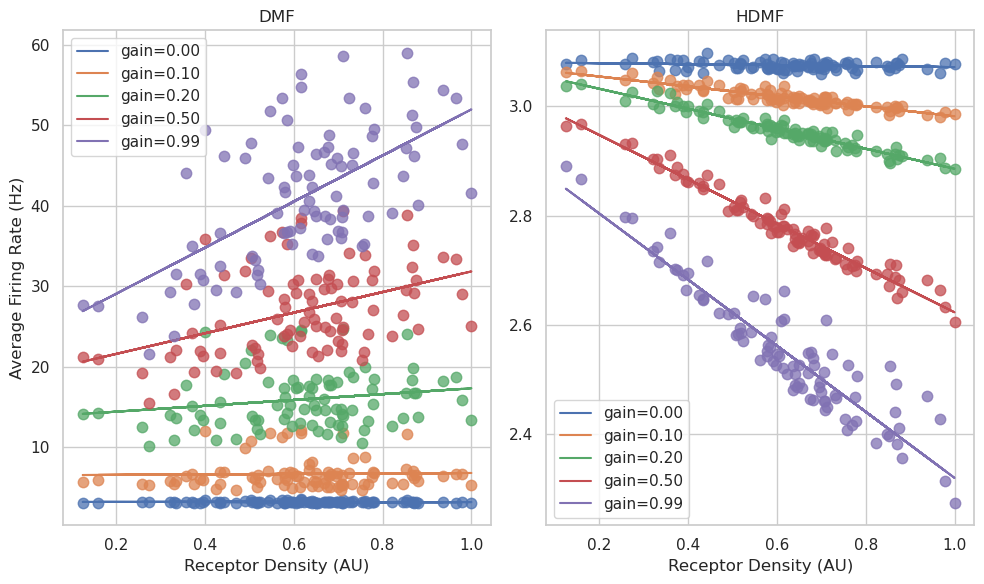

In [30]:
# FR modulation with the receptor density
titles= ['DMF','HDMF']
lr_vals = np.logspace(0,2.46,10)
alpha_vals = [0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95, 1.05]
sc_rec = loadmat(datafolder+'SC_and_5ht2a_receptors.mat')
receptors = sc_rec['receptors']
gains2plot = [0, 10, 20, 50, 99]

figname = 'fr_vs_neuromod_scatter'
fig = plt.figure(figsize=(10, 6))
nm_2_plot = [6,0]

for d in range(2):
    plt.subplot(1,2,d+1)
    for g in gains2plot:
        # plt.plot(receptors,nm_mean_fr[d][nm_2_plot[d],g,:],'.', 
        #          label='gain = '+str(g/100), markersize=15, alpha=0.75)
        plot, = plt.plot(receptors,nm_mean_fr[d][nm_2_plot[d],g,:],'.', markersize=15, alpha=0.75)
        # Compute the linear fit
        coeffs = np.polyfit(np.squeeze(receptors), nm_mean_fr[d][nm_2_plot[d],g,:], 1)
        linear_fit = np.poly1d(coeffs)        
        # Plot the linear fit
        plt.plot(receptors, linear_fit(receptors), '-', color=plot.get_color(),
                 label=f'gain={g/100:.2f}')
        
        plt.xlabel('Receptor Density (AU)')            
        plt.title(titles[d])
        if d==0:
            plt.ylabel('Average Firing Rate (Hz)')

    plt.legend()    
plt.tight_layout()

plt.show()


# fig.savefig(figfold+figname+'.png', dpi=300)
# fig.savefig(figfold+figname+'.pdf')

In [31]:
# FR modulation with the receptor density
import statsmodels.api as sm
titles= ['DMF','HDMF']
lr_vals = np.logspace(0,2.46,10)
alpha_vals = [0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95, 1.05]
sc_rec = loadmat(datafolder+'SC_and_5ht2a_receptors.mat')
receptors = sc_rec['receptors']
gains2plot = [0, 10, 20, 50, 99]

figname = 'fr_vs_neuromod_scatter'
fig = plt.figure(figsize=(10, 6))
nm_2_plot = [6,0]

for d in range(2):
    plt.subplot(1, 2, d + 1)
    for g in gains2plot:
        y_data = nm_mean_fr[d][nm_2_plot[d], g, :]
        plot, = plt.plot(receptors, y_data, '.', markersize=15, alpha=0.75)
        
        # Fit the linear regression model using statsmodels
        X = sm.add_constant(np.squeeze(receptors))  # Add an intercept to the model
        model = sm.OLS(y_data, X).fit()
        predictions = model.get_prediction(X)
        frame = predictions.summary_frame(alpha=0.05)
        
        # Plot the linear fit with the same color
        plt.plot(receptors, frame['mean'], '-', color=plot.get_color(),
                 label=f'gain={g/100:.2f}, y={model.params[1]:.2f}x+{model.params[0]:.2f}')
        
        # Plot the confidence interval
        sort_ids = np.argsort(np.squeeze(receptors))
        plt.fill_between(np.squeeze(receptors[sort_ids]).T, frame['mean_ci_lower'][sort_ids], 
                         frame['mean_ci_upper'][sort_ids], color=plot.get_color(), alpha=0.3)
        
        plt.xlabel('Receptor Density (AU)')
        plt.title(titles[d])
        if d == 0:
            plt.ylabel('Average Firing Rate (Hz)')
    plt.legend()

plt.tight_layout()
plt.show()


# fig.savefig(figfold+figname+'.png', dpi=300)
# fig.savefig(figfold+figname+'.pdf')

ModuleNotFoundError: No module named 'statsmodels'

In [91]:
frame['mean_ci_lower']

0     2.601827
1     2.564923
2     2.383595
3     2.527752
4     2.382591
        ...   
85    2.298648
86    2.491916
87    2.339501
88    2.546957
89    2.629269
Name: mean_ci_lower, Length: 90, dtype: float64

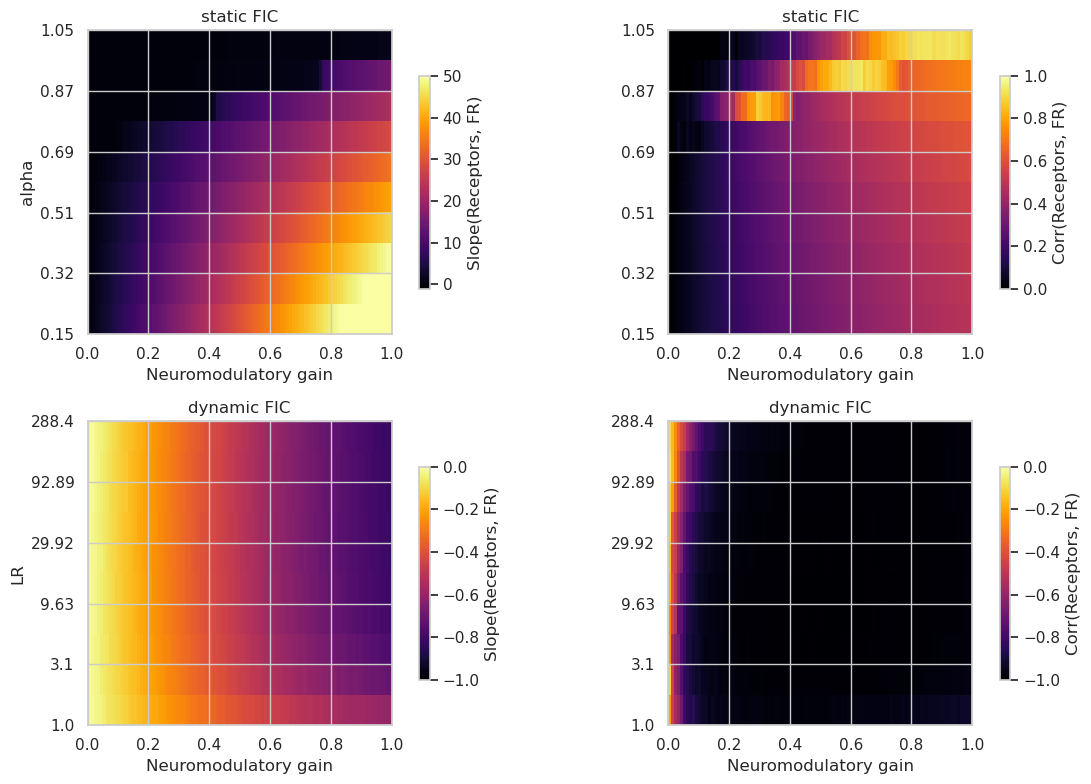

In [33]:
# LR vs Correlation
# LR_range = np.logspace(0,2.46,10)
# ,extent=(xmin,xmax,ymin,ymax))
titles = ['static FIC', 'dynamic FIC']
yticks = [np.floor(np.linspace(0.15, 1.05, 6)*100)/100, np.floor((np.logspace(0,2.46,6))*100)/100]
ylabel = ['alpha', 'LR']
slope_rec_fr_rs = np.dstack((slope_rec_fr))
res_rec_fr_rs = np.dstack((res_rec_fr))
corr_rec_fr_rs = np.dstack((corr_rec_fr))


s_vmin = [-1, -1]
s_vmax = [50, 0]
r_vmin = [0, 2.9]
r_vmax = [50, 3.3]
c_vmin = [0,-1]
c_vmax = [1,0]
figname = 'lr_vs_corr_fr_rec'
fig = plt.figure(figsize=(12, 8))
cont = 1

for p in range(2):
    # Slope
    plt.subplot(2,2,cont)
    plt.imshow(slope_rec_fr_rs[p,:,:].T,origin='lower', 
               vmin=s_vmin[p], vmax=s_vmax[p], cmap='inferno', interpolation='none', extent=(0,100,0,100))
    plt.title(titles[p])
    plt.colorbar(label='Slope(Receptors, FR)',shrink=0.7)    
    plt.yticks(ticks=np.linspace(0,100,6), labels=yticks[p])
    plt.ylabel(ylabel[p])
    plt.xticks(ticks=np.linspace(0,100,6), labels=np.linspace(0,100,6)/100)
    plt.xlabel('Neuromodulatory gain') 

    # Correlation
    plt.subplot(2,2,cont+1)
    plt.imshow(corr_rec_fr_rs[p,:,:].T,origin='lower', 
               vmin=c_vmin[p], vmax=c_vmax[p], cmap='inferno', interpolation='none', extent=(0,100,0,100))
    plt.title(titles[p])
    plt.colorbar(label='Corr(Receptors, FR)',shrink=0.7)    
    plt.yticks(ticks=np.linspace(0,100,6), labels=yticks[p])
    plt.xticks(ticks=np.linspace(0,100,6), labels=np.linspace(0,100,6)/100)
    plt.xlabel('Neuromodulatory gain') 
    # plt.ylabel(ylabel[p])

    cont=3
    


plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')

### II.- Fitting to fMRI

In [16]:
# Loading data
# Homeostatic fit
emp_data = loadmat(datafolder+'CNT_data.mat')
fc_fit = [] # 0=static, 1=dynamic
fcd_fit = [] # 0=static, 1=dynamic
fc_fit.append(loadmat(datafolder+'FitteoObservables/stat_fc.mat'))
fc_fit.append(loadmat(datafolder+'FitteoObservables/dyn_fc.mat'))

fcd_fit.append(loadmat(datafolder+'FitteoObservables/stat_fcd.mat'))
fcd_fit.append(loadmat(datafolder+'FitteoObservables/dyn_fcd.mat'))

# Repeated simulation at optima
fc_reps = np.load(datafolder+'RepeticionesSimulaciones/fcs_grid.npy')
fcd_reps = np.load(datafolder+'RepeticionesSimulaciones/fcds_grid.npy')





In [17]:
np.shape(fc_fit[0]['emp_fc'])
np.shape(fc_reps)

(2, 100, 90, 90)

In [18]:
# Extracting empirical FC and FCD
from scipy.stats import ks_2samp
emp_fcd = list()
nsubs = 13
fcd_dim = 78
fcd_triu_ids = np.triu_indices(fcd_dim,k=1)
for s in range(nsubs):
    aux = fcd_fit[0]['emp_fcd'][s,:,:]
    emp_fcd.append(aux[fcd_triu_ids])
    
emp_fcd = np.hstack((emp_fcd))


sim_fcd_stat = list()
sim_fcd_dyn = list()
nreps = 100
sim_fcd_dim = 154
sim_fcd_triu_ids = np.triu_indices(sim_fcd_dim,k=1)
rep_ks = np.zeros((2,nreps))
rep_corr = np.zeros((2,nreps))
fc_triu_ids = np.triu_indices(90,k=1)
emp_triu = fc_fit[0]['emp_fc'][fc_triu_ids]
for r in range(nreps):
    
    # Static FCD
    aux = fcd_reps[0,r,:,:]
    sim_fcd_stat.append(aux[sim_fcd_triu_ids])
    rep_ks[0,r] = ks_2samp(aux[sim_fcd_triu_ids],emp_fcd)[0]
    # Static FC    
    sim_triu = fc_reps[0,r,:,:]
    sim_triu = sim_triu[fc_triu_ids]
    aux = np.corrcoef(sim_triu,emp_triu)    
    rep_corr[0,r] = aux[0][1]
    # Dynamic FCD
    aux = fcd_reps[1,r,:,:]
    sim_fcd_dyn.append(aux[sim_fcd_triu_ids])
    rep_ks[1,r] = ks_2samp(aux[sim_fcd_triu_ids],emp_fcd)[0]
    # Dynamic FCD    
    sim_triu = fc_reps[1,r,:,:]
    sim_triu = sim_triu[fc_triu_ids]
    aux = np.corrcoef(sim_triu,emp_triu)    
    rep_corr[1,r] = aux[0][1]


sim_fcd_stat = np.hstack((sim_fcd_stat))
sim_fcd_dyn = np.hstack((sim_fcd_dyn))

## Computing ks for each repetition

In [19]:
# rep_corr

In [20]:
# np.shape(fcd_reps['emp_fcd'])
# fcd_fit
np.shape(emp_fcd)
np.shape(sim_fcd_dyn)
# rep_ks
col_pal = sns.color_palette()
col_pal

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

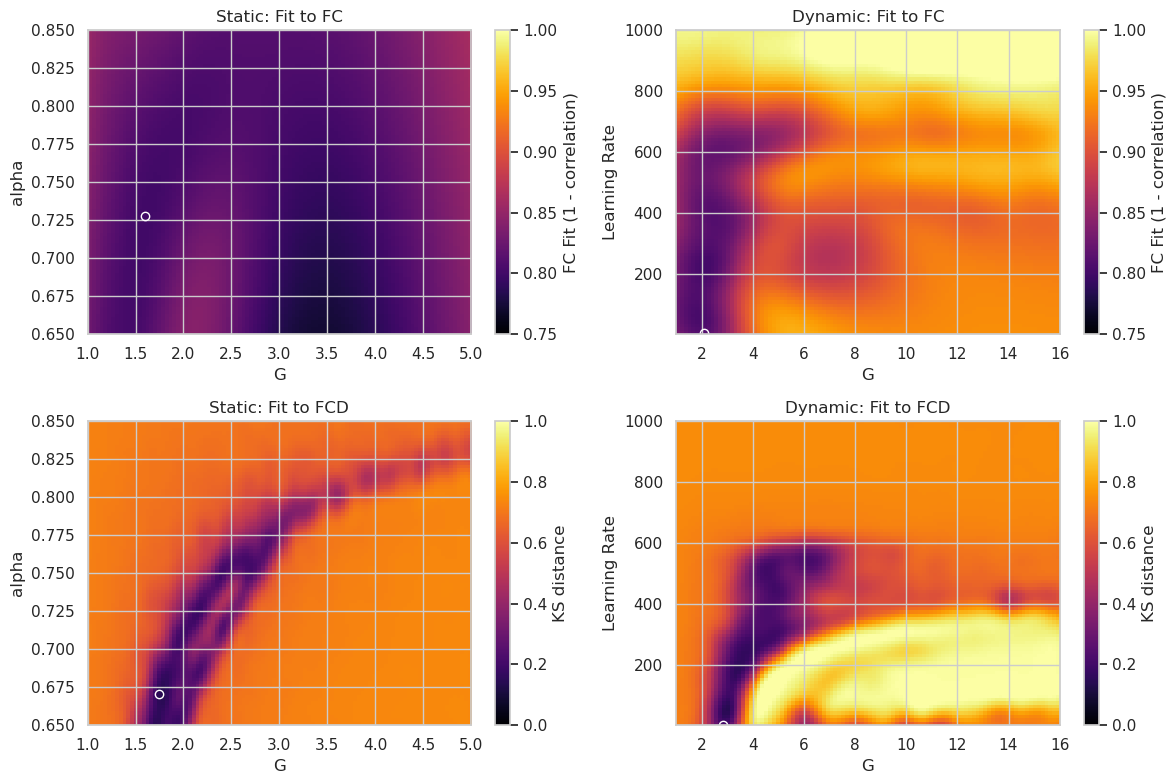

In [21]:
# Plotting output of bayesian optimization
figname = 'bayesian_op_output'

fc_stat_alpha_space = np.squeeze(fc_fit[0]['alpha_space'])
fc_stat_g_space = np.squeeze(fc_fit[0]['G_space'])
fc_dyn_lr_space = np.squeeze(fc_fit[1]['lr_space'])
fc_dyn_g_space = np.squeeze(fc_fit[1]['G_space'])

fcd_stat_alpha_space = np.squeeze(fc_fit[0]['alpha_space'])
fcd_stat_g_space = np.squeeze(fc_fit[0]['G_space'])
fcd_dyn_lr_space = np.squeeze(fc_fit[1]['lr_space'])
fcd_dyn_g_space = np.squeeze(fc_fit[1]['G_space'])


fig = plt.figure(figsize=(12, 8))
# STATIC FC FIT
plt.subplot(2,2,1)
plt.imshow(fc_fit[0]['funcEvals_stat'].T, cmap='inferno', 
           extent=(fc_stat_g_space[0], fc_stat_g_space[-1], fc_stat_alpha_space[0], fc_stat_alpha_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0.75, vmax=1)
plt.colorbar(label='FC Fit (1 - correlation)')
plt.ylabel('alpha')
plt.xlabel('G')
plt.plot(fc_fit[0]['G_stat_fc'],fc_fit[0]['alpha_stat_fc'],'o',color='w', markerfacecolor='None')
# plt.plot(fc_fit[0]['alpha_stat_fc'],fc_fit[0]['G_stat_fc'],'o',color='w', markerfacecolor='None')
plt.title('Static: Fit to FC')

# DYNAMIC FC FIT
plt.subplot(2,2,2)
plt.imshow(fc_fit[1]['funcEvals'].T, cmap='inferno', 
           extent=(fc_dyn_g_space[0], fc_dyn_g_space[-1], fc_dyn_lr_space[0], fc_dyn_lr_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0.75, vmax=1)
plt.colorbar(label='FC Fit (1 - correlation)')
plt.ylabel('Learning Rate')
plt.xlabel('G')
plt.plot(fc_fit[1]['G_dyn_fc'],fc_fit[1]['lr_dyn_fc'],'o',color='w', markerfacecolor='None')
plt.title('Dynamic: Fit to FC')

# STATIC FCD FIT
plt.subplot(2,2,3)
plt.imshow(fcd_fit[0]['funcEvals_stat'].T, cmap='inferno', 
           extent=(fcd_stat_g_space[0], fcd_stat_g_space[-1], fcd_stat_alpha_space[0], fcd_stat_alpha_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='KS distance')
plt.ylabel('alpha')
plt.xlabel('G')
plt.plot(fcd_fit[0]['G_stat_fcd'],fcd_fit[0]['alpha_stat_fcd'],'o',color='w', markerfacecolor='None')
plt.title('Static: Fit to FCD')

# DYNAMIC FCD FIT
plt.subplot(2,2,4)
plt.imshow(fcd_fit[1]['funcEvals'].T, cmap='inferno', 
           extent=(fcd_dyn_g_space[0], fcd_dyn_g_space[-1], fcd_dyn_lr_space[0], fcd_dyn_lr_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1 )
plt.colorbar(label='KS distance')
plt.ylabel('Learning Rate')
plt.xlabel('G')
plt.plot(fcd_fit[1]['G_dyn_fcd'],fcd_fit[1]['lr_dyn_fcd'],'o',color='w', markerfacecolor='None')
plt.title('Dynamic: Fit to FCD')



plt.tight_layout()
plt.show()

# fig.savefig(figfold+figname+'.png', dpi=300)
# fig.savefig(figfold+figname+'.pdf')



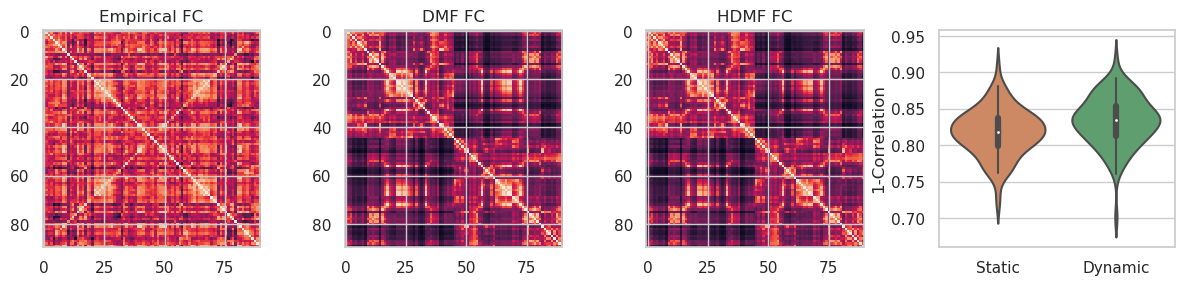

In [37]:
# Plotting repeated simulations at optima for FCD
ave_static_fc = np.mean(fc_reps[0,:,:,:],axis=0)
ave_dynamic_fc = np.mean(fc_reps[1,:,:,:],axis=0)
figname = 'FC_repeated_sim_fit'
col_pal = sns.color_palette()

fig = plt.figure(figsize=(12, 8))

# FC matrices
plt.subplot(3,4,1)
plt.imshow(fc_fit[0]['emp_fc'], interpolation='none')
plt.title('Empirical FC')

plt.subplot(3,4,2)
plt.imshow(ave_static_fc, interpolation='none')
plt.title('DMF FC')

plt.subplot(3,4,3)
plt.imshow(ave_dynamic_fc, interpolation='none')
plt.title('HDMF FC')

# Violins with goodness of fit
plt.subplot(3,4,4)
sns.violinplot(1-rep_corr.T, palette=col_pal[1:3])
plt.xticks(ticks=[0,1], labels=['Static', 'Dynamic'])
plt.ylabel('1-Correlation')

plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')


Text(0, 0.5, '1-Correlation')

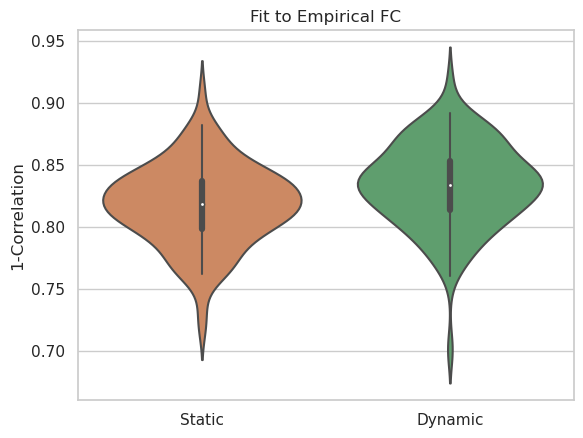

In [36]:
sns.violinplot(1-rep_corr.T, palette=col_pal[1:3])
plt.xticks(ticks=[0,1], labels=['Static', 'Dynamic'])
plt.title("Fit to Empirical FC")
plt.ylabel('1-Correlation')

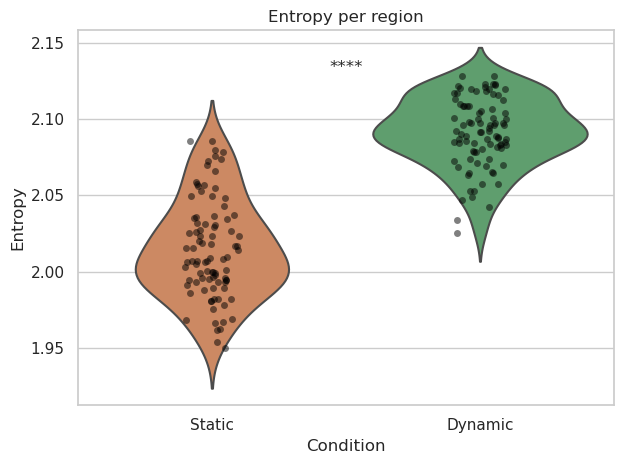

In [39]:
sns.stripplot(x='Condition', y='Entropy', data=data, jitter=True, color='black', alpha=0.5)
sns.violinplot(x='Condition', y='Entropy', data=data, inner=None,palette=col_pal[1:3])
plt.title('Entropy per region')
# Add paired test to see if distributions are different
_, p = ks_2samp(entropies_stat, entropies_dyn)
if p < 0.05:
    plt.text(0.5, 0.9, '****', ha='center', va='center', transform=plt.gca().transAxes)


plt.ylabel('Entropy')


plt.tight_layout()
plt.show()

In [ ]:

# Violins with goodness of fit
plt.subplot(3,4,5)
sns.violinplot(1-rep_corr.T, palette=col_pal[1:3])
plt.xticks(ticks=[0,1], labels=['Static', 'Dynamic'])
plt.title("Fit to Empirical FC")
plt.ylabel('1-Correlation')

plt.subplot(3, 4, 6)
sns.stripplot(x='Condition', y='Entropy', data=data, jitter=True, color='black', alpha=0.5)
sns.violinplot(x='Condition', y='Entropy', data=data, inner=None)
plt.title('Entropy per region')
# Add paired test to see if distributions are different
_, p = ks_2samp(entropies_stat, entropies_dyn)
if p < 0.05:
    plt.text(0.5, 0.9, '****', ha='center', va='center', transform=plt.gca().transAxes)


plt.ylabel('Entropy')


plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')


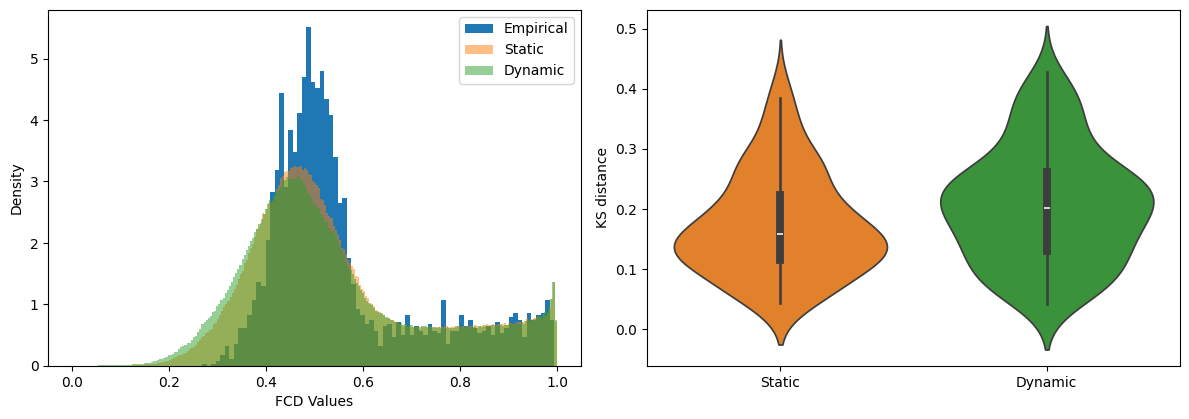

In [67]:
# Plotting repeated simulations at optima for FCD
figname = 'FCD_repeated_sim_fit'
col_pal = sns.color_palette()

fig = plt.figure(figsize=(12, 8))
# STATIC FC FIT
plt.subplot(2,2,1)
sns.histplot(emp_fcd, stat='density', legend=False, linewidth=0, label='Empirical', alpha=1)
sns.histplot(sim_fcd_stat, stat='density', legend=False, linewidth=0, label='Static', alpha=0.5)
sns.histplot(sim_fcd_dyn, stat='density', legend=False, linewidth=0, label='Dynamic', alpha=0.5)
# sns.histplot([emp_fcd, sim_fcd_stat, sim_fcd_dyn], stat='percent', legend=False)
# plt.hist([emp_fcd, sim_fcd_stat, sim_fcd_dyn], density=True)
# sns.histplot([sim_fcd_dyn], stat='percent', legend=False)
# plt.legend(['Empirical','Static','Dynamic'])
plt.xlabel('FCD Values')
plt.legend()


plt.subplot(2,2,2)
sns.violinplot(rep_ks.T, palette=col_pal[1:3])
plt.xticks(ticks=[0,1], labels=['Static', 'Dynamic'])
plt.ylabel('KS distance')

plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')


In [64]:
# Statistcal tests between distributions
from scipy.stats import wilcoxon
ks, p_fcd = ks_2samp(rep_ks[0,:],rep_ks[1,:])
ks_corr, p_fc = ks_2samp(rep_corr[0,:],rep_corr[1,:])

_, w_p_fcd= wilcoxon(rep_ks[0,:],rep_ks[1,:])
_, w_p_fc= wilcoxon(rep_corr[0,:],rep_corr[1,:])
[p_fcd, p_fc, w_p_fcd,w_p_fc]

[0.009878183186176536,
 0.0061340334218580265,
 0.0005853250706648852,
 3.3463326057616274e-10]

## Falta figura con las entropías de las regiones

In [63]:
 wilcoxon(rep_corr[0,:],rep_corr[1,:])

WilcoxonResult(statistic=698.0, pvalue=3.3463326057616274e-10)

### III.- A potential mechanism for whole-brain slow-waves

In [157]:
peak_val_ac_grid = np.load(datafolder+'slow_waves/peak_autocorrelation_grid.npy')
peak_time_ac_grid = np.load(datafolder+'slow_waves/peak_time_grid.npy')
corr_to_sc_grid = np.load(datafolder+'slow_waves/corr_to_sc_grid.npy')
rates_grid = np.load(datafolder+'slow_waves/rates_grid.npy')
homeo_fit_grid = np.load(datafolder+'slow_waves/homeostatic_fittness_grid.npy')

In [8]:

## Rangos
np.shape(peak_val_ac_grid)

(8, 60, 100)

In [60]:
np.max(np.std(0.1*peak_time_ac_grid,axis=0))

1270.654234046383

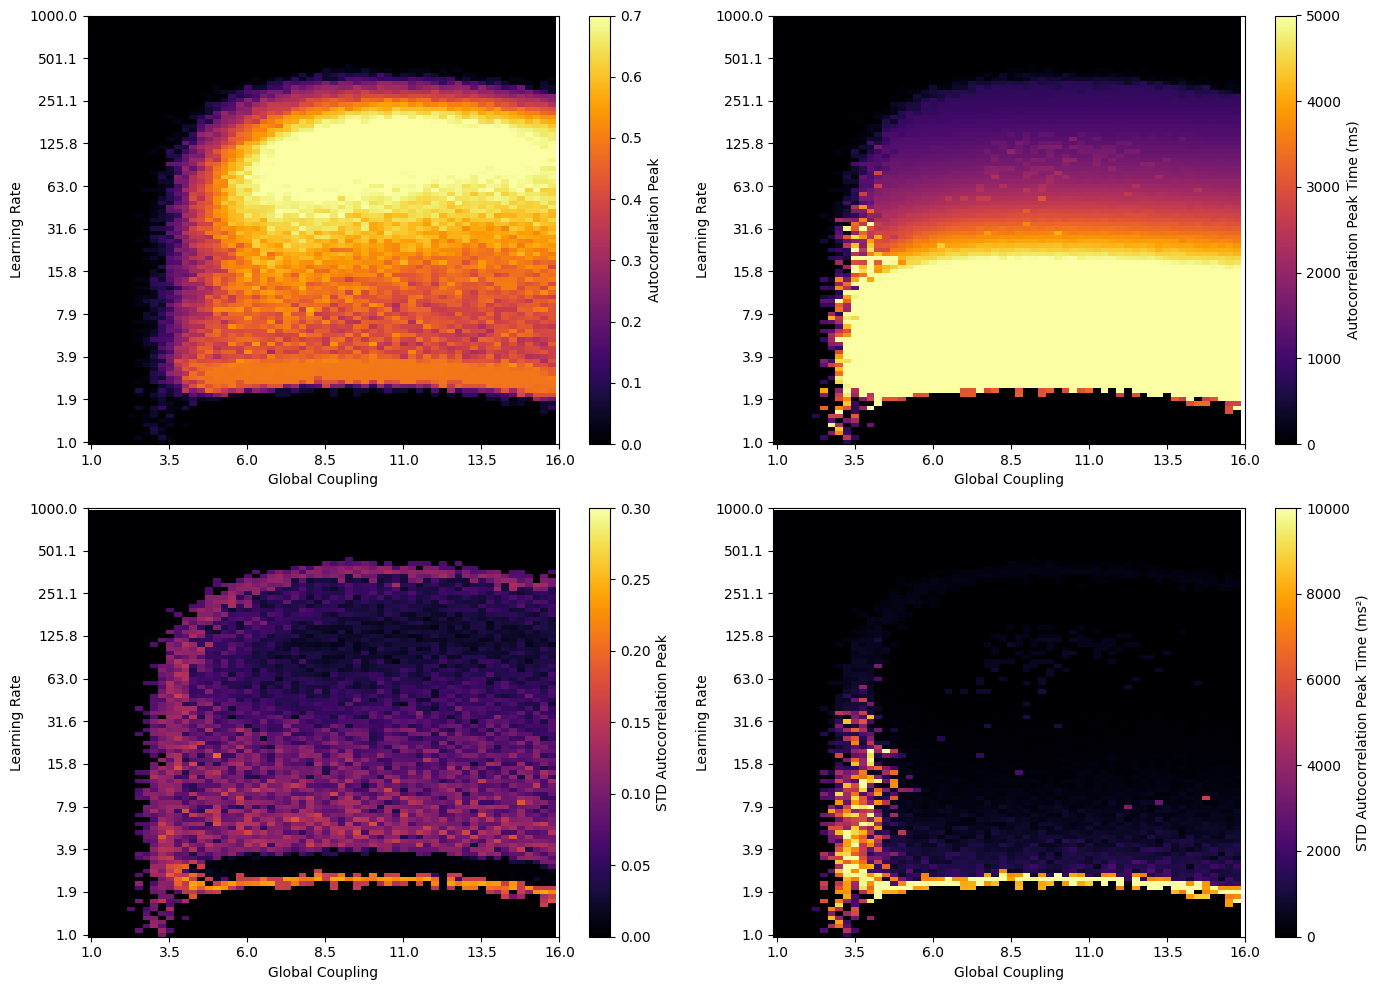

In [7]:
# Plotting ACF peak and Time
figname = 'slow_waves_ACF_peak_and_time'
G_max = 16
G_step = 0.25
G_range = np.arange(1,G_max,G_step)
LR_range = np.logspace(0, 3,100)
ngs = len(G_range)
nlrs = len(LR_range)



fig = plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plt.imshow(np.mean(peak_val_ac_grid,axis=0).T,vmin=0, vmax=0.7,cmap='inferno', 
           interpolation='none',origin='lower', aspect='auto')
plt.yticks(ticks=np.arange(0,nlrs+1,10),labels=np.floor(10*np.logspace(0,3,11))/10)
plt.xticks(ticks=np.arange(0,ngs+1,10), labels=np.linspace(1,G_max,7))
plt.ylabel('Learning Rate')
plt.xlabel('Global Coupling')
plt.colorbar(label='Autocorrelation Peak')

plt.subplot(2,2,2)
plt.imshow(np.mean(peak_time_ac_grid,axis=0).T,vmin=0, vmax=5000,cmap='inferno', 
           interpolation='none',origin='lower', aspect='auto')
plt.yticks(ticks=np.arange(0,nlrs+1,10),labels=np.floor(10*np.logspace(0,3,11))/10)
plt.xticks(ticks=np.arange(0,ngs+1,10), labels=np.linspace(1,G_max,7))
plt.ylabel('Learning Rate')
plt.xlabel('Global Coupling')
plt.colorbar(label='Autocorrelation Peak Time (ms)')

plt.subplot(2,2,3)
plt.imshow(np.std(peak_val_ac_grid,axis=0).T,vmin=0, vmax=0.3,cmap='inferno', 
           interpolation='none',origin='lower', aspect='auto')
plt.yticks(ticks=np.arange(0,nlrs+1,10),labels=np.floor(10*np.logspace(0,3,11))/10)
plt.xticks(ticks=np.arange(0,ngs+1,10), labels=np.linspace(1,G_max,7))
plt.ylabel('Learning Rate')
plt.xlabel('Global Coupling')
plt.colorbar(label='STD Autocorrelation Peak')

plt.subplot(2,2,4)
plt.imshow(np.std(peak_time_ac_grid,axis=0).T,vmin=0, vmax=10000,cmap='inferno', 
           interpolation='none',origin='lower', aspect='auto')
plt.yticks(ticks=np.arange(0,nlrs+1,10),labels=np.floor(10*np.logspace(0,3,11))/10)
plt.xticks(ticks=np.arange(0,ngs+1,10), labels=np.linspace(1,G_max,7))
plt.ylabel('Learning Rate')
plt.xlabel('Global Coupling')
plt.colorbar(label='STD Autocorrelation Peak Time (ms²)')

plt.tight_layout()
fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')
plt.show()


## Plotting timeserires and autocorrelation function

In [46]:
e_rates_tseries = np.load(datafolder+'slow_waves/time_series_examples/rates_results.npy')
rates_tseries = np.load(datafolder+'slow_waves/time_series_examples/rates_inh_results.npy')
fic_tseries = np.load(datafolder+'slow_waves/time_series_examples/fic_t_results.npy')
gvals_tseries = np.load(datafolder+'slow_waves/time_series_examples/G_vals.npy')
np.shape(e_rates_tseries)

(3, 90, 90000)

In [47]:
from scipy.signal import find_peaks, correlate

def get_peak_and_ms(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    peaks, _ = find_peaks(autocorr, height=(0.2,0.8), prominence=0.2)
    if peaks.size==0:
        autocorr_value = 0
        time = 0
    else:
        autocorr_value = autocorr[peaks[0]]
        time = peaks[0]
    return autocorr, autocorr_value, time

def cross_corr(x, y):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]

    return crosscorr


In [48]:
acorr = list()
acorr_peak = np.zeros((3))
acorr_time = np.zeros((3))
xcorr_rate_fic = list()
for d in range(3):
    aux_acorr, acorr_peak[d], acorr_time[d] = get_peak_and_ms(np.mean(e_rates_tseries[d,:,:],axis=0)[None,:])
    acorr.append(aux_acorr)
    # xcorr between fic and rates
    x=np.mean(e_rates_tseries[d,:,:],axis=0)
    x=(x-np.mean(x))/np.std(x)
    
    y=np.mean(fic_tseries[d,:,:],axis=0)
    y=(y-np.mean(y))/np.std(y)
    corr = correlate(x, y, mode='full')             
    xcorr_rate_fic.append(corr/len(x))    
    
acorrs = np.vstack((acorr))
np.shape(acorrs)    
    

(3, 90000)

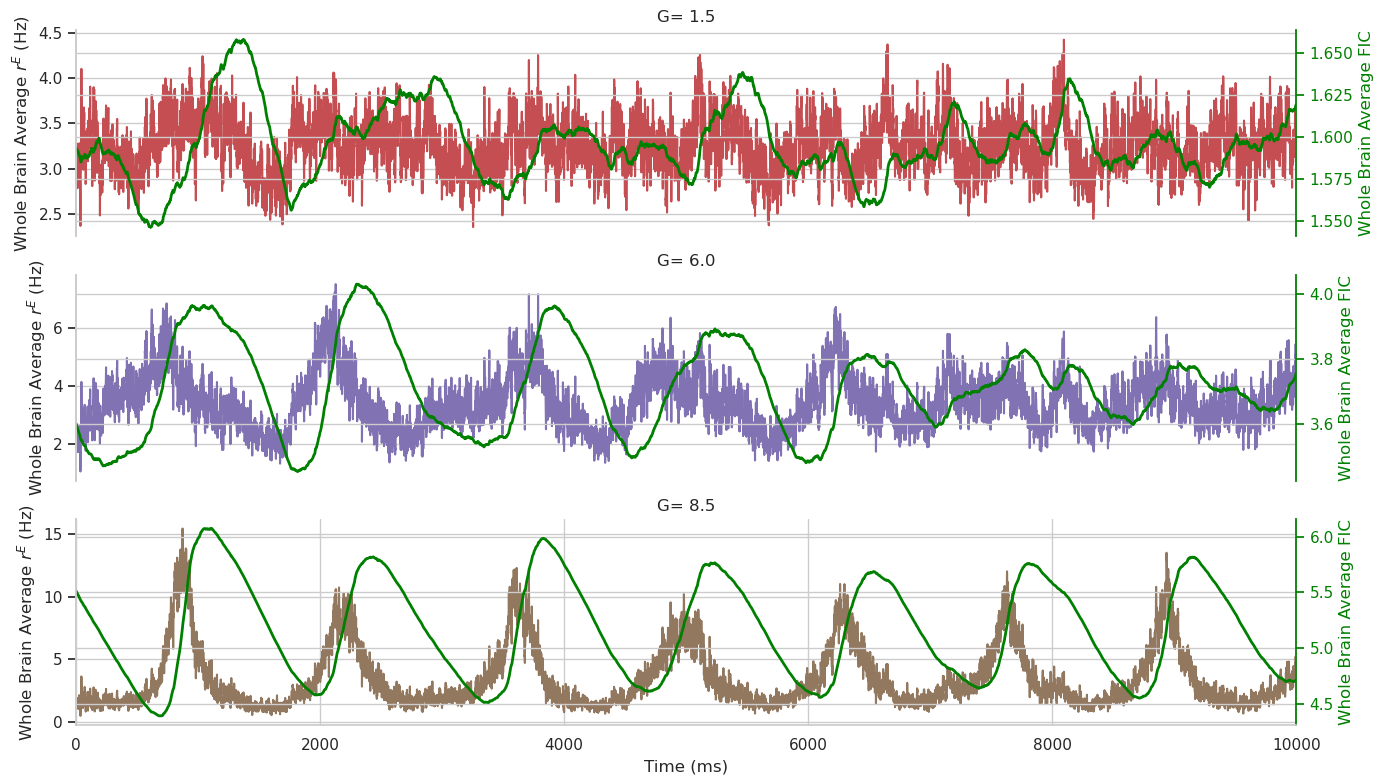

In [49]:
# Plottin timeseries
max_t = 10000
acor_tbase = np.arange(0,max_t)
acor_tbase_s = np.arange(0,max_t)*0.001
figname = 'three_timeseries'
fig, axes = plt.subplots(3, 1, figsize=(14, 8))


for e in range(3):
    ax = axes[e]
    ax.plot(acor_tbase, np.mean(e_rates_tseries[e, :, :max_t], axis=0), color=col_pal[3+e])
    
    # Create a twin Axes for the right y-axis
    ax2 = ax.twinx()
    ax2.plot(acor_tbase, np.mean(fic_tseries[e, :, :max_t], axis=0), color='green', linewidth=2)  # Plot on the right y-axis
    
    ax.set_ylabel(r'Whole Brain Average $r^E$ (Hz)')
    ax2.set_ylabel(r'Whole Brain Average FIC', color='green')
    # Set the color of the ticks and tick labels on the right y-axis
    ax2.yaxis.set_tick_params(color='green', labelcolor='green')    
    # Set the color of the vertical axis line on the right y-axis
    ax2.spines['right'].set_color('green')
    if e==2:
        ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticks([])
    ax.set_title(f'G= {gvals_tseries[e]}')
    plt.xlim([0,max_t])

    ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    # ax2.spines['right'].set_visible(False)
    # ax2.spines['left'].set_visible(False)
    if e<2:
        ax2.spines['bottom'].set_visible(False)    
    

plt.tight_layout()
fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')
plt.show()

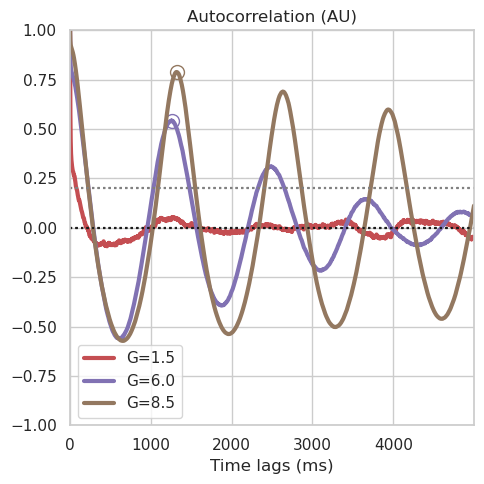

In [54]:
t_len = np.shape(acorrs)[1]
max_t = 5000
acor_tbase = np.arange(0,max_t)
acor_tbase_s = np.arange(0,max_t)*0.001
xcorr_tbase = np.arange(- max_t/2, max_t/2)

# Extacting max of the xcorr
sel_xcorr = np.vstack(([x[int(t_len - max_t/2):int(t_len + max_t/2)] for x in xcorr_rate_fic]))
max_xcorr_id = np.argmax(sel_xcorr, axis=1)
min_xcorr_id = np.argmin(sel_xcorr, axis=1)
# [[[sel_xcorr[x,min_xcorr_id[x]] for x in range(3)], xcorr_tbase[min_xcorr_id]],
# [[sel_xcorr[x,max_xcorr_id[x]] for x in range(3)], xcorr_tbase[max_xcorr_id]]]


pp = list()
figname = 'autocorr_and_cross_corr'
fig = plt.figure(figsize=(10, 5))
for e in range(3):
    plt.subplot(1,2,1)
    plt.plot(acor_tbase, acorrs[e,0:max_t], 
         color=col_pal[3+e], linewidth=3, label='G='+str(gvals_tseries[e]))
    if e>0:
        plt.plot(acorr_time[e],acorr_peak[e],'o',color=col_pal[3+e],
                 markersize=10, fillstyle='none')
    pp.append(auxp)
    plt.ylim([-1,1])
    plt.title('Autocorrelation (AU)')
    plt.xlabel('Time lags (ms)')
    plt.plot([acor_tbase[0],acor_tbase[-1]],[0,0],'k:')
    plt.plot([acor_tbase[0],acor_tbase[-1]],[0.2,0.2],':',color=[0.5,0.5,0.5])
    plt.xlim([acor_tbase[0],acor_tbase[-1]])
    if e==2:
        plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(xcorr_tbase, xcorr_rate_fic[e][int(t_len - max_t/2):int(t_len + max_t/2)], 
             color=col_pal[3+e], linewidth=3)
    plt.plot(xcorr_tbase[max_xcorr_id[e]], sel_xcorr[e,max_xcorr_id[e]],
            'o',color=col_pal[3+e],markersize=10, fillstyle='none')
    plt.plot(xcorr_tbase[min_xcorr_id[e]], sel_xcorr[e,min_xcorr_id[e]],
        'o',color=col_pal[3+e],markersize=10, fillstyle='none')
    plt.ylim([-1,1])
    plt.plot([0,0],[-1,1],'k:')
    plt.plot([xcorr_tbase[0],xcorr_tbase[-1]],[0,0],'k:')
    plt.xlim([xcorr_tbase[0],xcorr_tbase[-1]])
    plt.title('Cross-correlation ($<r^E>_{WB}$,<FIC>) (AU)')
    plt.xlabel('Time lags (ms)')
    



plt.tight_layout()
fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')
plt.show()

In [44]:
t_len = np.shape(acorrs)[1]
max_t = 5000
acor_tbase = np.arange(0,max_t)
acor_tbase_s = np.arange(0,max_t)*0.001
xcorr_tbase = np.arange(- max_t/2, max_t/2)

# Extacting max of the xcorr
sel_xcorr = np.vstack(([x[int(t_len - max_t/2):int(t_len + max_t/2)] for x in xcorr_rate_fic]))
max_xcorr_id = np.argmax(sel_xcorr, axis=1)
min_xcorr_id = np.argmin(sel_xcorr, axis=1)
# [[[sel_xcorr[x,min_xcorr_id[x]] for x in range(3)], xcorr_tbase[min_xcorr_id]],
# [[sel_xcorr[x,max_xcorr_id[x]] for x in range(3)], xcorr_tbase[max_xcorr_id]]]


pp = list()
figname = 'autocorr_and_cross_corr'
fig = plt.figure(figsize=(10, 5))
for e in range(3):
    plt.subplot(1,1,1)
    plt.plot(acor_tbase, acorrs[e,0:max_t], 
         color=col_pal[3+e], linewidth=3, label='G='+str(gvals_tseries[e]))
    if e>0:
        plt.plot(acorr_time[e],acorr_peak[e],'o',color=col_pal[3+e],
                 markersize=10, fillstyle='none')
    pp.append(auxp)
    plt.ylim([-1,1])
    plt.title('Autocorrelation (AU)')
    plt.xlabel('Time lags (ms)')
    plt.plot([acor_tbase[0],acor_tbase[-1]],[0,0],'k:')
    plt.plot([acor_tbase[0],acor_tbase[-1]],[0.2,0.2],':',color=[0.5,0.5,0.5])
    plt.xlim([acor_tbase[0],acor_tbase[-1]])
    if e==2:
        plt.legend()




plt.tight_layout()
plt.show()

NameError: name 'acorrs' is not defined

In [309]:
np.shape(sel_xcorr)
max_xcorr

array([2288, 2216, 2225])

In [ ]:
# Sanity checks
fig = plt.figure(figsize=(14, 10))

# Correlation SC-FC
plt.subplot(2,4,1)
plt.imshow(np.mean(corr_to_sc_grid,axis=0).T,vmin=0, vmax=1,cmap='inferno', 
           interpolation='none',origin='lower', aspect='auto')
plt.yticks(ticks=np.arange(0,nlrs+1,10),labels=np.floor(10*np.logspace(0,3,11))/10)
plt.xticks(ticks=np.arange(0,ngs+1,10), labels=np.linspace(1,G_max,7))
plt.ylabel('Learning Rate')
plt.xlabel('Global Coupling')
plt.colorbar(label='Corr(SC,FC)')


plt.subplot(2,4,2)
plt.imshow(np.mean(corr_to_sc_grid,axis=0).T,vmin=0, vmax=1,cmap='inferno', 
           interpolation='none',origin='lower', aspect='auto')
plt.yticks(ticks=np.arange(0,nlrs+1,10),labels=np.floor(10*np.logspace(0,3,11))/10)
plt.xticks(ticks=np.arange(0,ngs+1,10), labels=np.linspace(1,G_max,7))
plt.ylabel('Learning Rate')
plt.xlabel('Global Coupling')
plt.colorbar(label='Corr(SC,FC)')